## SRJ - Trying new things

## Trying to change the 

In [1]:
#Check the possible excitations
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import itertools
import time
import re
import scipy
from scipy.optimize import minimize
ash_excitation = []
energies = []
excitations= []
old_grad = []
excitationlist = []
generatingfns = []
gs_energy = []
operator_check = []  # To store the highest gradient excitation operators
theta = np.pi/4
print('Theta is', theta)

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity



bond_length = 2.0
symbols = ["H","H","H","H"]
electrons = 4
orbitals = 8
r_bohr = bond_length *1.8897259886 
r_bohr = bond_length * 1.0  # Convert bond length to Bohr radius 
coordinates = np.array([[0.0,0.0, 1*r_bohr], [0.0, 0.0, 2*r_bohr], [0.0,0.0,3*r_bohr],[0.0, 0.0, 4*r_bohr]])
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-3g", method="pyscf")
#hf_state = qchem.hf_state(electrons, qubits)

def adaptvqe(adapt_it = 4, e_th=1e-12):
    ash_excitation = []
    energies = []
    excitations= []
    #Preparation of the Hartree-Fock state in the form of 2^8 states
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def hf_stateprep(wires):
        target_state = np.zeros(2**qubits)
        target_state[240] = 1.0 # Every molecule change, you need to change this index
        qml.StatePrep(target_state, wires=range(qubits))
        return qml.state()

    hf_state = hf_stateprep(wires=qubits)
    #print('HF state is', hf_state)

    #Calculation of HF state
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def circuit(hf_state, electrons, qubits, H):
        #print('Updated hf_state is', hf_state)  
        qml.StatePrep(hf_state, wires=range(qubits))
        return qml.expval(H)  
    
    @qml.qnode(dev)
    def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w)   #Calculating the commutator
        return qml.expval(res)
    
    # Commutator calculation for other states except HF state
    @qml.qnode(dev)
    def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w) #Calculating the commutator
        return qml.expval(res)
    #Applyign the givens rotation to the HF state
    @qml.qnode(dev)
    def new_state(hf_state, ash_excitation, qubits):
        qml.StatePrep(hf_state, wires=range(qubits))
        for i in range(len(ash_excitation)):
            if len(ash_excitation[i]) == 4:
                qml.DoubleExcitation(theta, wires=ash_excitation[i])
            elif len(ash_excitation[i]) == 2:
                qml.SingleExcitation(theta, wires=ash_excitation[i])
        return qml.state()
    
    #Measurement of new state
    dev_meas = qml.device("lightning.qubit", wires=qubits, shots=1000)
    @qml.qnode(dev_meas)
    def measure(ostate):
        qml.StatePrep(ostate, wires=range(qubits))
        return qml.counts()
    
  


    print('HF state is', circuit(hf_state, electrons, qubits, H))
    singles, doubles = qml.qchem.excitations(electrons, orbitals)

    
    op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in singles]
    op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in doubles]
    operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
    print('The operator pool length is', len(operator_pool))
    states = [hf_state]
    max_operator = None

    for j in range(adapt_it):
        print('The adapt iteration now is', j)  #Adapt iteration
        max_value = float('-inf')
        #max_operator = None
        k = states[-1] if states else hf_state  # if states is empty, fall back to hf_state
        counts1 = measure(k)  #Measure the current state
        print('The measurement of new state is', counts1)
        print(f'The operator check for this iteration {j} is', operator_check)
        for i in operator_pool:
            if i not in operator_check:  # Check if the operator is already used
                #print('The current excitation operator is', i) #Current excitation operator - fermionic one
                #print('The value of  operator check is', operator_check)  #Max excitation operator
                w = qml.fermi.jordan_wigner(i)  #JW transformation
                if np.array_equal(k, hf_state): # If the current state is the HF state
                    current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated  
                else:
                    current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated
                #print(f'The expectation value of {i} is', current_value)

                if current_value > max_value:
                    max_value = current_value
                    max_operator = i

        print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value
        operator_check.append(max_operator)
        # Convert operator to excitations and append to ash_excitation
        indices_str = re.findall(r'\d+', str(max_operator))
        excitations1 = [int(index) for index in indices_str]
        print('Highest gradient excitation is', excitations1)
        ash_excitation.append(excitations1)
        print('ash_excitation is', ash_excitation)
        print('The length of ash_excitation before generating matrix is', len(ash_excitation))

        
        #Now apply the givens rotation for it. 
        ostate = new_state(hf_state, ash_excitation, qubits)
        print(qml.draw(new_state, max_length=100)(hf_state,ash_excitation, qubits))
        #Measuring the state
        counts = measure(ostate)
        print('State count after Generating function is', counts)
        states.append(ostate)   
        print('After adding new state, the length of states is', len(states))
        M = np.zeros((len(states), len(states)), dtype=complex)  # Initialize H with zeros
        S = np.zeros((len(states), len(states)), dtype=complex)  # Initialize S matrix with zeros
        Ham_matrix = qml.matrix(H, wire_order=range(qubits))  # Get the Hamiltonian matrix
        #print('Shape of Hamiltonian matrix is', Ham_matrix.shape)
        # Now we need to fill the H and S matrices
        for i in range(len(states)):
            for j in range(len(states)):
                
                #print('The value of i and j is', i, j)
                left_op = states[i].T.conj()
                right_op = states[j]
                M[i,j] = left_op.dot(Ham_matrix.dot(right_op)).real
                #print(f'The value of i and j', i, j, 'in M', M[i,j])
                S[i,j] = left_op.dot(right_op).real
                #print(f'The value of i and j', i, j, 'is', S[i,j])
                #S[i,j] = (states[i].conj().T) @ states[j] #<psi_i|psi_j>
                #print(f'The value of i and j', i, j, 'is', S[i,j])
                #M[i,j] = (states[i].conj().T) @ Ham_matrix @ states[j]
                
                if i != j:
                    M[j,i] = M[i,j].conj()
                    S[j,i] = S[i,j].conj()
        n = S.shape[0]
        epsilon = 1e-10
        S_reg = S + epsilon * np.eye(n)
        print(f'S matrix with {i} and {j} is', S)
        print('Hamiltonian Matrix with', i, j, 'is', M)
        eig,evec=scipy.linalg.eigh(M,S_reg)
        print('Eigenvalues are', eig)
        gs_energy.append(eig[0])
        print('Ground state energy is', gs_energy) 
        
    return ash_excitation, states,eig,gs_energy, Ham_matrix,hf_state


Theta is 0.7853981633974483


In [2]:
ash_excitation, states,eig,gs_energy,Ham_matrix, hf_state = adaptvqe(adapt_it=25, e_th=1e-12)

HF state is -2.0752428267412464
The operator pool length is 26
The adapt iteration now is 0
The measurement of new state is {'11110000': 1000}
The operator check for this iteration 0 is []


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.2747856899916047 for operator a⁺(2) a⁺(3) a(4) a(5)
Highest gradient excitation is [2, 3, 4, 5]
ash_excitation is [[2, 3, 4, 5]]
The length of ash_excitation before generating matrix is 1
0: ─╭|Ψ⟩───────────┤  State
1: ─├|Ψ⟩───────────┤  State
2: ─├|Ψ⟩─╭G²(0.79)─┤  State
3: ─├|Ψ⟩─├G²(0.79)─┤  State
4: ─├|Ψ⟩─├G²(0.79)─┤  State
5: ─├|Ψ⟩─╰G²(0.79)─┤  State
6: ─├|Ψ⟩───────────┤  State
7: ─╰|Ψ⟩───────────┤  State
State count after Generating function is {'11001100': 128, '11110000': 872}
After adding new state, the length of states is 2
S matrix with 1 and 1 is [[1.        +0.j 0.92387953-0.j]
 [0.92387953+0.j 1.        +0.j]]
Hamiltonian Matrix with 1 1 is [[-2.07524283+0.j -1.96985234-0.j]
 [-1.96985234+0.j -2.06918274+0.j]]
Eigenvalues are [-2.10107988 -1.34463357]
Ground state energy is [-2.101079884775418]
The adapt iteration now is 1
The measurement of new state is {'11001100': 151, '11110000': 849}
The operator check for this iteration 1 is [a⁺(2) a⁺(3

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.2782736465288686 for operator a⁺(1) a⁺(2) a(5) a(6)
Highest gradient excitation is [1, 2, 5, 6]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6]]
The length of ash_excitation before generating matrix is 2
0: ─╭|Ψ⟩─────────────────────┤  State
1: ─├|Ψ⟩───────────╭G²(0.79)─┤  State
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─┤  State
3: ─├|Ψ⟩─├G²(0.79)─│─────────┤  State
4: ─├|Ψ⟩─├G²(0.79)─│─────────┤  State
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─┤  State
6: ─├|Ψ⟩───────────╰G²(0.79)─┤  State
7: ─╰|Ψ⟩─────────────────────┤  State
State count after Generating function is {'10010110': 133, '11001100': 139, '11110000': 728}
After adding new state, the length of states is 3
S matrix with 2 and 2 is [[1.        +0.j 0.92387953-0.j 0.85355339-0.j]
 [0.92387953+0.j 1.        +0.j 0.93502712-0.j]
 [0.85355339+0.j 0.93502712+0.j 1.        +0.j]]
Hamiltonian Matrix with 2 2 is [[-2.07524283+0.j -1.96985234-0.j -1.78852254-0.j]
 [-1.96985234+0.j -2.06918274+0.j -1.87740527-0.j]
 [-1.78852254+0.

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.24349774641783117 for operator a⁺(0) a⁺(3) a(4) a(7)
Highest gradient excitation is [0, 3, 4, 7]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7]]
The length of ash_excitation before generating matrix is 3
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─┤  State
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────┤  State
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────┤  State
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─┤  State
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─┤  State
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────┤  State
6: ─├|Ψ⟩───────────╰G²(0.79)─│─────────┤  State
7: ─╰|Ψ⟩─────────────────────╰G²(0.79)─┤  State
State count after Generating function is {'00001111': 19, '01101001': 112, '10010110': 98, '11001100': 158, '11110000': 613}
After adding new state, the length of states is 4
S matrix with 3 and 3 is [[1.        +0.j 0.92387953-0.j 0.85355339-0.j 0.78858051-0.j]
 [0.92387953+0.j 1.        +0.j 0.93502712-0.j 0.875     -0.j]
 [0.85355339+0.j 0.93502712+0.j 1.       

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.2527533149082193 for operator a⁺(0) a⁺(3) a(5) a(6)
Highest gradient excitation is [0, 3, 5, 6]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6]]
The length of ash_excitation before generating matrix is 4
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)─┤  State
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────┤  State
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────┤  State
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─┤  State
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────┤  State
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─┤  State
6: ─├|Ψ⟩───────────╰G²(0.79)─│─────────╰G²(0.79)─┤  State
7: ─╰|Ψ⟩─────────────────────╰G²(0.79)───────────┤  State
State count after Generating function is {'00001111': 17, '01100110': 97, '01101001': 99, '10010110': 110, '10011001': 3, '11001100': 154, '11110000': 520}
After adding new state, the length of states is 5
S matrix with 4 and 4 is [[1.        +0.j 0.92387953-0.j 0.85355339-

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.23184323047032773 for operator a⁺(1) a⁺(2) a(4) a(7)
Highest gradient excitation is [1, 2, 4, 7]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7]]
The length of ash_excitation before generating matrix is 5
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────┤  State
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─┤  State
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─┤  State
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────┤  State
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─┤  State
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────┤  State
6: ─├|Ψ⟩───────────╰G²(0.79)─│─────────╰G²(0.79)─│─────────┤  State
7: ─╰|Ψ⟩─────────────────────╰G²(0.79)───────────╰G²(0.79)─┤  State
State count after Generating function is {'00001111': 46, '01100110': 64, '01101001': 123, '10010110': 117, '10011001': 42, '11001100': 157, '11110000': 451}
After adding new stat

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.2794868490411072 for operator a⁺(0) a⁺(1) a(6) a(7)
Highest gradient excitation is [0, 1, 6, 7]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7]]
The length of ash_excitation before generating matrix is 6
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─┤  State
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─┤  State
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────┤  State
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────┤  State
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────┤  State
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────┤  State
6: ─├|Ψ⟩───────────╰G²(0.79)─│─────────╰G²(0.79)─│─────────├G²(0.79)─┤  State
7: ─╰|Ψ⟩─────────────────────╰G²(0.79)───────────╰G²(0.79)─╰G²(0.79)─┤  State
State count after Generating function is {'00001111': 134, '00110011': 78, '01100110':

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.11104327404067138 for operator a⁺(0) a⁺(2) a(4) a(6)
Highest gradient excitation is [0, 2, 4, 6]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6]]
The length of ash_excitation before generating matrix is 7
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)─┤  State
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────┤  State
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─┤  State
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────┤  State
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─┤  State
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────┤  State
6: ─├|Ψ⟩───────────╰G²(0.79)─│─────────╰G²(0.79)─│─────────├G²(0.79)─╰G²(0.79)─┤  State
7: ─╰|Ψ⟩─────────────────────╰G²(0.79)───────────╰G²(0.79)─╰G²(0.79)───────────

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.11159976919235269 for operator a⁺(1) a⁺(3) a(5) a(7)
Highest gradient excitation is [1, 3, 5, 7]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7]]
The length of ash_excitation before generating matrix is 8
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────┤  State
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─┤  State
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────┤  State
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─┤  State
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────┤  State
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─┤  State
6: ─├|Ψ⟩───────────╰G²(0.79)─│─────────╰G²(0.79)─│─────────├G²(0.79)─╰G²(0.79)─│─────────┤  S

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.10455966626277466 for operator a⁺(0) a(4)
Highest gradient excitation is [0, 4]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4]]
The length of ash_excitation before generating matrix is 9
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)─┤
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│────────┤
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│────────┤
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│────────┤
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)─┤
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────├G²(0.79)──────────┤
6: ─├|Ψ⟩───────────╰G²(0.79)─│─────────╰G²(0.79)─│─────────├G²(0.79)─╰G²(0.79)─│──────────

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.2923249099852161 for operator a⁺(3) a(7)
Highest gradient excitation is [3, 7]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7]]
The length of ash_excitation before generating matrix is 10
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─────────
6: ─├|Ψ⟩───────────╰G²(0.79)─│─────────╰G²(0.79)─│─────────├G²(0.79)─╰G²(0.79)─│──────────────

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.19243101498917253 for operator a⁺(2) a(6)
Highest gradient excitation is [2, 6]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6]]
The length of ash_excitation before generating matrix is 11
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─────────
6: ─├|Ψ⟩───────────╰G²(0.79)─│─────────╰G²(0.79)─│─────────├G²(0.79)─╰G²(0.79)─│─────

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.06921344426310039 for operator a⁺(1) a(5)
Highest gradient excitation is [1, 5]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5]]
The length of ash_excitation before generating matrix is 12
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─────────
6: ─├|Ψ⟩───────────╰G²(0.79)─│─────────╰G²(0.79)─│─────────├G²(0.79)─╰G²(0.79

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.09492215978927022 for operator a⁺(2) a⁺(3) a(6) a(7)
Highest gradient excitation is [2, 3, 6, 7]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7]]
The length of ash_excitation before generating matrix is 13
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─────────
6: ─├|Ψ⟩───────────╰G²(0.79)─│─────────╰G²(0.7

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.11158094150773146 for operator a⁺(0) a⁺(1) a(4) a(5)
Highest gradient excitation is [0, 1, 4, 5]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7], [0, 1, 4, 5]]
The length of ash_excitation before generating matrix is 14
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─────────
6: ─├|Ψ⟩───────────╰G²(0.79)─│──

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 1.1560719181526218e-48 for operator a⁺(0) a(6)
Highest gradient excitation is [0, 6]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7], [0, 1, 4, 5], [0, 6]]
The length of ash_excitation before generating matrix is 15
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─────────
6: ─├|Ψ⟩───────────╰G²(0.79)─│────────

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.2746923156496614 for operator a⁺(2) a⁺(3) a(4) a(7)
Highest gradient excitation is [2, 3, 4, 7]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7], [0, 1, 4, 5], [0, 6], [2, 3, 4, 7]]
The length of ash_excitation before generating matrix is 16
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─────────
6: ─├|Ψ⟩───

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.2929871383993967 for operator a⁺(1) a(7)
Highest gradient excitation is [1, 7]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7], [0, 1, 4, 5], [0, 6], [2, 3, 4, 7], [1, 7]]
The length of ash_excitation before generating matrix is 17
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─────────
6: ─├|Ψ⟩───────────╰

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.20508757924207957 for operator a⁺(3) a(5)
Highest gradient excitation is [3, 5]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7], [0, 1, 4, 5], [0, 6], [2, 3, 4, 7], [1, 7], [3, 5]]
The length of ash_excitation before generating matrix is 18
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─────────
6: ─├|Ψ⟩───

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.24174880954764152 for operator a⁺(0) a⁺(3) a(6) a(7)
Highest gradient excitation is [0, 3, 6, 7]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7], [0, 1, 4, 5], [0, 6], [2, 3, 4, 7], [1, 7], [3, 5], [0, 3, 6, 7]]
The length of ash_excitation before generating matrix is 19
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│────────

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.19183456699031828 for operator a⁺(0) a⁺(1) a(4) a(7)
Highest gradient excitation is [0, 1, 4, 7]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7], [0, 1, 4, 5], [0, 6], [2, 3, 4, 7], [1, 7], [3, 5], [0, 3, 6, 7], [0, 1, 4, 7]]
The length of ash_excitation before generating matrix is 20
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│────

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.14047188531880156 for operator a⁺(0) a⁺(3) a(4) a(5)
Highest gradient excitation is [0, 3, 4, 5]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7], [0, 1, 4, 5], [0, 6], [2, 3, 4, 7], [1, 7], [3, 5], [0, 3, 6, 7], [0, 1, 4, 7], [0, 3, 4, 5]]
The length of ash_excitation before generating matrix is 21
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.11877383120349957 for operator a⁺(1) a⁺(2) a(6) a(7)
Highest gradient excitation is [1, 2, 6, 7]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7], [0, 1, 4, 5], [0, 6], [2, 3, 4, 7], [1, 7], [3, 5], [0, 3, 6, 7], [0, 1, 4, 7], [0, 3, 4, 5], [1, 2, 6, 7]]
The length of ash_excitation before generating matrix is 22
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│──────

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


The highest operator value is 0.08954625774248731 for operator a⁺(0) a⁺(1) a(5) a(6)
Highest gradient excitation is [0, 1, 5, 6]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7], [0, 1, 4, 5], [0, 6], [2, 3, 4, 7], [1, 7], [3, 5], [0, 3, 6, 7], [0, 1, 4, 7], [0, 3, 4, 5], [1, 2, 6, 7], [0, 1, 5, 6]]
The length of ash_excitation before generating matrix is 23
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


The highest operator value is 0.09210815044531473 for operator a⁺(2) a(4)
Highest gradient excitation is [2, 4]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7], [0, 1, 4, 5], [0, 6], [2, 3, 4, 7], [1, 7], [3, 5], [0, 3, 6, 7], [0, 1, 4, 7], [0, 3, 4, 5], [1, 2, 6, 7], [0, 1, 5, 6], [2, 4]]
The length of ash_excitation before generating matrix is 24
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


The highest operator value is 0.045731452725723994 for operator a⁺(2) a⁺(3) a(5) a(6)
Highest gradient excitation is [2, 3, 5, 6]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7], [0, 1, 4, 5], [0, 6], [2, 3, 4, 7], [1, 7], [3, 5], [0, 3, 6, 7], [0, 1, 4, 7], [0, 3, 4, 5], [1, 2, 6, 7], [0, 1, 5, 6], [2, 4], [2, 3, 5, 6]]
The length of ash_excitation before generating matrix is 25
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)

In [3]:
gs_energy
#ash_excitation

[-2.101079884775418,
 -2.1133641432496733,
 -2.1206815799382825,
 -2.121637272623519,
 -2.1272551045345676,
 -2.1381198624393143,
 -2.13834614821147,
 -2.142149542684055,
 -2.1421873820844652,
 -2.1422987635175934,
 -2.1449845453573135,
 -2.145187700582728,
 -2.1453855359007084,
 -2.146817045528614,
 -2.146818240005326,
 -2.146818586578,
 -2.146819485033613,
 -2.1468247000648506,
 -2.146873237479683,
 -2.1468853043764144,
 -2.1468954453605424,
 -2.1469006394358274,
 -2.146901392306721,
 -2.147118355523489,
 -2.1471952445011233]

In [4]:
FCI = -2.15100714

In [5]:
gs_energy[-1] - FCI

0.0038118954988766163

## FCI data in Bohr unit

In [6]:
from pyscf import gto, scf, mcscf
import numpy as np
#coordinates = np.array([[0.0,0.0, 0.0], [0.0, 0.0, 1.20*r_bohr], [1.20*r_bohr,0.0,-0.336000*r_bohr],[-0.475176*r_bohr, -0.823029*r_bohr, -0.336000*r_bohr]])
# Define the molecule
mol = gto.M(
    atom='H 0 0 0; H 0 0 2.0; H 0 0 4.0; H 0 0 6.0',
    basis='sto-3g',
    unit = 'Bohr',  # Use Bohr units
    verbose=1  # Optional: Adjusts verbosity for output
)
 
# Perform Restricted Hartree-Fock calculation
mf = scf.RHF(mol)
mf.kernel()
 
# Get the HF energy
hf_energy = mf.e_tot
print("Hartree-Fock Ground State Energy:", hf_energy)
 
# Define the active space
ncas = 4  # Number of active orbitals - spatial it seems
nelecas = 4  # Number of electrons in the active space
 
# Set up the CASCI/CASSCF solver
mycas = mcscf.CASCI(mf, ncas, nelecas)
 
 
mycas.fcisolver.nroots=2
 
# Compute the CASCI/CASSCF energy
e_casci = mycas.kernel()
 
# Output the results
print("CASCI/CASSCF Ground State Energy:", e_casci)
print("Hartree-Fock Ground State Energy:", hf_energy)

Hartree-Fock Ground State Energy: -2.0752428267263405


CASCI/CASSCF Ground State Energy: (array([-2.15100714, -1.94610375]), array([-4.31767381, -4.11277042]), [FCIvector([[ 9.61031734e-01,  4.99600361e-16,  5.23904734e-03,
             4.42167350e-03, -1.10281184e-16, -3.23882836e-02],
           [-5.22652059e-16, -2.03293319e-01,  1.57777380e-16,
             2.62625374e-16,  5.58156551e-02,  3.91310612e-17],
           [ 5.23904734e-03,  2.76013186e-16, -6.88150212e-02,
             8.82039387e-02, -9.28061155e-17, -3.57214741e-03],
           [ 4.42167350e-03,  3.12325778e-16,  8.82039387e-02,
            -4.56451569e-02, -1.56141009e-16, -4.65726203e-03],
           [ 1.41649745e-16,  5.58156551e-02, -1.46351184e-16,
            -1.92857450e-16, -5.92203614e-02, -1.98889889e-17],
           [-3.23882836e-02, -5.74913423e-17, -3.57214741e-03,
            -4.65726203e-03,  6.31238718e-17,  2.66879990e-02]]), FCIvector([[-8.55849484e-16,  6.76251163e-01,  2.64260798e-15,
            -1.45794384e-15, -1.32053983e-01, -6.76486718e-16],
   

## Generalized singles and doubles

In [7]:
import numpy as np
import pennylane as qml

def generalized_singles(wires, delta_sz):
    r"""Return generalized single excitation terms

    .. math::
        \hat{T_1} = \sum_{pq} t_{p}^{q} \hat{c}^{\dagger}_{q} \hat{c}_{p}

    """
    sz = np.array(
        [0.5 if (i % 2 == 0) else -0.5 for i in range(len(wires))]
    )  # alpha-beta electrons
    gen_singles_wires = []
    for r in range(len(wires)):
        for p in range(len(wires)):
            if sz[p] - sz[r] == delta_sz and p != r:
                if r < p:
                    gen_singles_wires.append(wires[r : p + 1])
                else:
                    gen_singles_wires.append(wires[p : r + 1][::-1])
    return gen_singles_wires

u = generalized_singles(wires = [0,1,2,3,4,5,6,7], delta_sz= 0)

print(u)


GSD_singles = [[sublist[0], sublist[-1]] for sublist in u]
print('GSD singles',GSD_singles)
print('Length of GSD singles', len(GSD_singles))


[[0, 1, 2], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4, 5, 6], [1, 2, 3], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6, 7], [2, 1, 0], [2, 3, 4], [2, 3, 4, 5, 6], [3, 2, 1], [3, 4, 5], [3, 4, 5, 6, 7], [4, 3, 2, 1, 0], [4, 3, 2], [4, 5, 6], [5, 4, 3, 2, 1], [5, 4, 3], [5, 6, 7], [6, 5, 4, 3, 2, 1, 0], [6, 5, 4, 3, 2], [6, 5, 4], [7, 6, 5, 4, 3, 2, 1], [7, 6, 5, 4, 3], [7, 6, 5]]
GSD singles [[0, 2], [0, 4], [0, 6], [1, 3], [1, 5], [1, 7], [2, 0], [2, 4], [2, 6], [3, 1], [3, 5], [3, 7], [4, 0], [4, 2], [4, 6], [5, 1], [5, 3], [5, 7], [6, 0], [6, 2], [6, 4], [7, 1], [7, 3], [7, 5]]
Length of GSD singles 24


## GSD - DOubles

In [8]:
def generalized_pair_doubles(wires):
    r"""Return pair coupled-cluster double excitations

    .. math::
        \hat{T_2} = \sum_{pq} t_{p_\alpha p_\beta}^{q_\alpha, q_\beta}
               \hat{c}^{\dagger}_{q_\alpha} \hat{c}^{\dagger}_{q_\beta} \hat{c}_{p_\beta} \hat{c}_{p_\alpha}

    """
    pair_gen_doubles_wires = [
        [
            wires[r : r + 2],
            wires[p : p + 2],
        ]  # wires for [wires[r], wires[r+1], wires[p], wires[p+1]] terms
        for r in range(0, len(wires) - 1, 2)
        for p in range(0, len(wires) - 1, 2)
        if p != r  # remove redundant terms
    ]
    return pair_gen_doubles_wires

tdoubles = generalized_pair_doubles(wires = [0,1,2,3,4,5,6,7])
print((tdoubles))
print(len(tdoubles))

GSD_doubles = [[sublist[0][0], sublist[0][-1], sublist[1][0], sublist[1][-1]] for sublist in tdoubles]
print('GSD doubles', GSD_doubles)
print('length of GSD doubles', len(GSD_doubles))   

[[[0, 1], [2, 3]], [[0, 1], [4, 5]], [[0, 1], [6, 7]], [[2, 3], [0, 1]], [[2, 3], [4, 5]], [[2, 3], [6, 7]], [[4, 5], [0, 1]], [[4, 5], [2, 3]], [[4, 5], [6, 7]], [[6, 7], [0, 1]], [[6, 7], [2, 3]], [[6, 7], [4, 5]]]
12
GSD doubles [[0, 1, 2, 3], [0, 1, 4, 5], [0, 1, 6, 7], [2, 3, 0, 1], [2, 3, 4, 5], [2, 3, 6, 7], [4, 5, 0, 1], [4, 5, 2, 3], [4, 5, 6, 7], [6, 7, 0, 1], [6, 7, 2, 3], [6, 7, 4, 5]]
length of GSD doubles 12


In [14]:
## Create operator pool
op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in GSD_singles]
print(op1)
op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in GSD_doubles]
operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
print('The operator pool length is', len(operator_pool))

[a⁺(0) a(2), a⁺(0) a(4), a⁺(0) a(6), a⁺(1) a(3), a⁺(1) a(5), a⁺(1) a(7), a⁺(2) a(0), a⁺(2) a(4), a⁺(2) a(6), a⁺(3) a(1), a⁺(3) a(5), a⁺(3) a(7), a⁺(4) a(0), a⁺(4) a(2), a⁺(4) a(6), a⁺(5) a(1), a⁺(5) a(3), a⁺(5) a(7), a⁺(6) a(0), a⁺(6) a(2), a⁺(6) a(4), a⁺(7) a(1), a⁺(7) a(3), a⁺(7) a(5)]
The operator pool length is 36


## SRJ - Preparing new states - Bringing older states

## Perfectly running case

In [1]:
#Check the possible excitations
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import itertools
import time
import re
import scipy
from scipy.optimize import minimize
ash_excitation = []
energies = []
excitations= []
old_grad = []
excitationlist = []
generatingfns = []
gs_energy = []
operator_check = []  # To store the highest gradient excitation operators
theta = np.pi/4
print('Theta is', theta)

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity



bond_length = 2.0
symbols = ["H","H","H","H"]
electrons = 4
orbitals = 8
r_bohr = bond_length *1.8897259886 
r_bohr = bond_length * 1.0  # Convert bond length to Bohr radius 
coordinates = np.array([[0.0,0.0, 1*r_bohr], [0.0, 0.0, 2*r_bohr], [0.0,0.0,3*r_bohr],[0.0, 0.0, 4*r_bohr]])
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-3g", method="pyscf")
#hf_state = qchem.hf_state(electrons, qubits)

def adaptvqe(adapt_it = 4, e_th=1e-12):
    ash_excitation = []
    energies = []
    excitations= []
    #Preparation of the Hartree-Fock state in the form of 2^8 states
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def hf_stateprep(wires):
        target_state = np.zeros(2**qubits)
        target_state[240] = 1.0 # Every molecule change, you need to change this index
        qml.StatePrep(target_state, wires=range(qubits))
        return qml.state()

    hf_state = hf_stateprep(wires=qubits)
    #print('HF state is', hf_state)

    #Calculation of HF state
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def circuit(hf_state, electrons, qubits, H):
        #print('Updated hf_state is', hf_state)  
        qml.StatePrep(hf_state, wires=range(qubits))
        return qml.expval(H)  
    
    @qml.qnode(dev)
    def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w)   #Calculating the commutator
        return qml.expval(res)
    
    # Commutator calculation for other states except HF state
    @qml.qnode(dev)
    def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w) #Calculating the commutator
        return qml.expval(res)
    #Applyign the givens rotation to the HF state
    @qml.qnode(dev)
    def new_state(hf_state, ash_excitation, qubits):
        qml.StatePrep(hf_state, wires=range(qubits))
        for i in range(len(ash_excitation)):
            if len(ash_excitation[i]) == 4:
                qml.DoubleExcitation(theta, wires=ash_excitation[i])
            elif len(ash_excitation[i]) == 2:
                qml.SingleExcitation(theta, wires=ash_excitation[i])
        return qml.state()
    
    #Measurement of new state
    dev_meas = qml.device("lightning.qubit", wires=qubits, shots=1000)
    @qml.qnode(dev_meas)
    def measure(ostate):
        qml.StatePrep(ostate, wires=range(qubits))
        return qml.counts()
    
    @qml.qnode(dev)
    def ind_state(ash_excitation):
        qml.StatePrep(hf_state, wires=range(qubits))
        print('Individual excitation is', ash_excitation)
        if len(ash_excitation) == 4 :
            qml.DoubleExcitation(theta, wires=ash_excitation)
        elif len(ash_excitation) == 2:
            qml.SingleExcitation(theta, wires=ash_excitation)
        return qml.state()


    print('HF state is', circuit(hf_state, electrons, qubits, H))
    singles, doubles = qml.qchem.excitations(electrons, orbitals)

    
    op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in singles]
    op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in doubles]
    operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
    print('The operator pool length is', len(operator_pool))
    states = [hf_state]
    max_operator = None

    for j in range(1, adapt_it):
        print('The adapt iteration now is', j)  #Adapt iteration
        max_value = float('-inf')
        #max_operator = None
        k = states[-1] if states else hf_state  # if states is empty, fall back to hf_state
        counts1 = measure(k)  #Measure the current state
        print('The measurement of new state is', counts1)
        print(f'The operator check for this iteration {j} is', operator_check)
        for i in operator_pool:
            if i not in operator_check:  # Check if the operator is already used
                #print('The current excitation operator is', i) #Current excitation operator - fermionic one
                #print('The value of  operator check is', operator_check)  #Max excitation operator
                w = qml.fermi.jordan_wigner(i)  #JW transformation
                if np.array_equal(k, hf_state): # If the current state is the HF state
                    current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated  
                else:
                    current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated
                #print(f'The expectation value of {i} is', current_value)

                if current_value > max_value:
                    max_value = current_value
                    max_operator = i

        print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value
        operator_check.append(max_operator)
        # Convert operator to excitations and append to ash_excitation
        indices_str = re.findall(r'\d+', str(max_operator))
        excitations1 = [int(index) for index in indices_str]
        print('Highest gradient excitation is', excitations1)
        ash_excitation.append(excitations1)
        print('ash_excitation is', ash_excitation)
        print('The length of ash_excitation before generating matrix is', len(ash_excitation))

        
        #Now apply the givens rotation for it. 
        ostate = new_state(hf_state, ash_excitation, qubits)
        print(qml.draw(new_state, max_length=100)(hf_state,ash_excitation, qubits))
        #Measuring the state
        counts = measure(ostate)
        print('State count after Generating function is', counts)
        if j >= 2:
            states.append(ind_state(ash_excitation[-1]))  # Append the individual excitation state
        else:
            print('Skipping individual excitation state for j < 2')
        states.append(ostate)
        print(f'After adding the states the adapt iteration is {j} and no of states',len(states))
        M = np.zeros((len(states), len(states)), dtype=complex)  # Initialize H with zeros
        S = np.zeros((len(states), len(states)), dtype=complex)  # Initialize S matrix with zeros
        Ham_matrix = qml.matrix(H, wire_order=range(qubits))  # Get the Hamiltonian matrix
        #print('Shape of Hamiltonian matrix is', Ham_matrix.shape)
        # Now we need to fill the H and S matrices
        for i in range(len(states)):
            for j in range(len(states)):
                print('The value of i and j is', i, j)
                left_op = states[i].T.conj()
                right_op = states[j]
                M[i,j] = left_op.dot(Ham_matrix.dot(right_op)).real
                S[i,j] = left_op.dot(right_op).real
     
                
                if i != j:
                    M[j,i] = M[i,j].conj()
                    S[j,i] = S[i,j].conj()
        n = S.shape[0]
        epsilon = 1e-10
        S_reg = S + epsilon * np.eye(n)
        print(f'S matrix with {i} and {j} is', S)
        print('Hamiltonian Matrix with', i, j, 'is', M)
        print('The shape of S matrix is', S.shape)  
        eig,evec=scipy.linalg.eigh(M,S_reg)
        print('Eigenvalues are', eig)
        gs_energy.append(eig[0])
        print('Ground state energy is', gs_energy) 
          
    return ash_excitation, states,eig,gs_energy, Ham_matrix,hf_state


Theta is 0.7853981633974483


In [2]:
ash_excitation, states,eig,gs_energy,Ham_matrix, hf_state = adaptvqe(adapt_it=24, e_th=1e-12)

HF state is -2.075242826741247
The operator pool length is 26
The adapt iteration now is 1
The measurement of new state is {'11110000': 1000}
The operator check for this iteration 1 is []


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.2747856899916047 for operator a⁺(2) a⁺(3) a(4) a(5)
Highest gradient excitation is [2, 3, 4, 5]
ash_excitation is [[2, 3, 4, 5]]
The length of ash_excitation before generating matrix is 1
0: ─╭|Ψ⟩───────────┤  State
1: ─├|Ψ⟩───────────┤  State
2: ─├|Ψ⟩─╭G²(0.79)─┤  State
3: ─├|Ψ⟩─├G²(0.79)─┤  State
4: ─├|Ψ⟩─├G²(0.79)─┤  State
5: ─├|Ψ⟩─╰G²(0.79)─┤  State
6: ─├|Ψ⟩───────────┤  State
7: ─╰|Ψ⟩───────────┤  State
State count after Generating function is {'11001100': 145, '11110000': 855}
Skipping individual excitation state for j < 2
After adding the states the adapt iteration is 1 and no of states 2
The value of i and j is 0 0
The value of i and j is 0 1
The value of i and j is 1 0
The value of i and j is 1 1
S matrix with 1 and 1 is [[1.        +0.j 0.92387953-0.j]
 [0.92387953+0.j 1.        +0.j]]
Hamiltonian Matrix with 1 1 is [[-2.07524283+0.j -1.96985234-0.j]
 [-1.96985234+0.j -2.06918274+0.j]]
The shape of S matrix is (2, 2)
Eigenvalues are [-2.1010798

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.2782736465288686 for operator a⁺(1) a⁺(2) a(5) a(6)
Highest gradient excitation is [1, 2, 5, 6]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6]]
The length of ash_excitation before generating matrix is 2
0: ─╭|Ψ⟩─────────────────────┤  State
1: ─├|Ψ⟩───────────╭G²(0.79)─┤  State
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─┤  State
3: ─├|Ψ⟩─├G²(0.79)─│─────────┤  State
4: ─├|Ψ⟩─├G²(0.79)─│─────────┤  State
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─┤  State
6: ─├|Ψ⟩───────────╰G²(0.79)─┤  State
7: ─╰|Ψ⟩─────────────────────┤  State
State count after Generating function is {'10010110': 133, '11001100': 118, '11110000': 749}
Individual excitation is [1, 2, 5, 6]
After adding the states the adapt iteration is 2 and no of states 4
The value of i and j is 0 0
The value of i and j is 0 1
The value of i and j is 0 2
The value of i and j is 0 3
The value of i and j is 1 0
The value of i and j is 1 1
The value of i and j is 1 2
The value of i and j is 1 3
The value of i and j is 2 0
The value o

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.24349774641783117 for operator a⁺(0) a⁺(3) a(4) a(7)
Highest gradient excitation is [0, 3, 4, 7]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7]]
The length of ash_excitation before generating matrix is 3
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─┤  State
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────┤  State
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────┤  State
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─┤  State
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─┤  State
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────┤  State
6: ─├|Ψ⟩───────────╰G²(0.79)─│─────────┤  State
7: ─╰|Ψ⟩─────────────────────╰G²(0.79)─┤  State
State count after Generating function is {'00001111': 19, '01101001': 108, '10010110': 105, '11001100': 138, '11110000': 630}
Individual excitation is [0, 3, 4, 7]
After adding the states the adapt iteration is 3 and no of states 6
The value of i and j is 0 0
The value of i and j is 0 1
The value of i and j is 0 2
The value of i and j is 0 3
The value of i and j is

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.2527533149082193 for operator a⁺(0) a⁺(3) a(5) a(6)
Highest gradient excitation is [0, 3, 5, 6]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6]]
The length of ash_excitation before generating matrix is 4
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)─┤  State
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────┤  State
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────┤  State
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─┤  State
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────┤  State
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─┤  State
6: ─├|Ψ⟩───────────╰G²(0.79)─│─────────╰G²(0.79)─┤  State
7: ─╰|Ψ⟩─────────────────────╰G²(0.79)───────────┤  State
State count after Generating function is {'00001111': 5, '01100110': 105, '01101001': 118, '10010110': 92, '10011001': 5, '11001100': 156, '11110000': 519}
Individual excitation is [0, 3, 5, 6]
After adding the states the adapt iteration is 4 and no of states 8
The value of

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.23184323047032776 for operator a⁺(1) a⁺(2) a(4) a(7)
Highest gradient excitation is [1, 2, 4, 7]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7]]
The length of ash_excitation before generating matrix is 5
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────┤  State
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─┤  State
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─┤  State
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────┤  State
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─┤  State
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────┤  State
6: ─├|Ψ⟩───────────╰G²(0.79)─│─────────╰G²(0.79)─│─────────┤  State
7: ─╰|Ψ⟩─────────────────────╰G²(0.79)───────────╰G²(0.79)─┤  State
State count after Generating function is {'00001111': 65, '01100110': 61, '01101001': 111, '10010110': 92, '10011001': 53, '11001100': 135, '11110000': 483}
Individual excitation 

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.2794868490411072 for operator a⁺(0) a⁺(1) a(6) a(7)
Highest gradient excitation is [0, 1, 6, 7]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7]]
The length of ash_excitation before generating matrix is 6
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─┤  State
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─┤  State
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────┤  State
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────┤  State
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────┤  State
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────┤  State
6: ─├|Ψ⟩───────────╰G²(0.79)─│─────────╰G²(0.79)─│─────────├G²(0.79)─┤  State
7: ─╰|Ψ⟩─────────────────────╰G²(0.79)───────────╰G²(0.79)─╰G²(0.79)─┤  State
State count after Generating function is {'00001111': 121, '00110011': 72, '01100110':

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.11104327404067135 for operator a⁺(0) a⁺(2) a(4) a(6)
Highest gradient excitation is [0, 2, 4, 6]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6]]
The length of ash_excitation before generating matrix is 7
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)─┤  State
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────┤  State
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─┤  State
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────┤  State
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─┤  State
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────┤  State
6: ─├|Ψ⟩───────────╰G²(0.79)─│─────────╰G²(0.79)─│─────────├G²(0.79)─╰G²(0.79)─┤  State
7: ─╰|Ψ⟩─────────────────────╰G²(0.79)───────────╰G²(0.79)─╰G²(0.79)───────────

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.11159976919235269 for operator a⁺(1) a⁺(3) a(5) a(7)
Highest gradient excitation is [1, 3, 5, 7]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7]]
The length of ash_excitation before generating matrix is 8
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────┤  State
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─┤  State
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────┤  State
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─┤  State
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────┤  State
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─┤  State
6: ─├|Ψ⟩───────────╰G²(0.79)─│─────────╰G²(0.79)─│─────────├G²(0.79)─╰G²(0.79)─│─────────┤  S

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.10455966626277466 for operator a⁺(0) a(4)
Highest gradient excitation is [0, 4]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4]]
The length of ash_excitation before generating matrix is 9
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)─┤
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│────────┤
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│────────┤
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│────────┤
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)─┤
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────├G²(0.79)──────────┤
6: ─├|Ψ⟩───────────╰G²(0.79)─│─────────╰G²(0.79)─│─────────├G²(0.79)─╰G²(0.79)─│──────────

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.2923249099852161 for operator a⁺(3) a(7)
Highest gradient excitation is [3, 7]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7]]
The length of ash_excitation before generating matrix is 10
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─────────
6: ─├|Ψ⟩───────────╰G²(0.79)─│─────────╰G²(0.79)─│─────────├G²(0.79)─╰G²(0.79)─│──────────────

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.19243101498917253 for operator a⁺(2) a(6)
Highest gradient excitation is [2, 6]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6]]
The length of ash_excitation before generating matrix is 11
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─────────
6: ─├|Ψ⟩───────────╰G²(0.79)─│─────────╰G²(0.79)─│─────────├G²(0.79)─╰G²(0.79)─│─────

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.06921344426310037 for operator a⁺(1) a(5)
Highest gradient excitation is [1, 5]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5]]
The length of ash_excitation before generating matrix is 12
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─────────
6: ─├|Ψ⟩───────────╰G²(0.79)─│─────────╰G²(0.79)─│─────────├G²(0.79)─╰G²(0.79

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.09492215978927022 for operator a⁺(2) a⁺(3) a(6) a(7)
Highest gradient excitation is [2, 3, 6, 7]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7]]
The length of ash_excitation before generating matrix is 13
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─────────
6: ─├|Ψ⟩───────────╰G²(0.79)─│─────────╰G²(0.7

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.11158094150773146 for operator a⁺(0) a⁺(1) a(4) a(5)
Highest gradient excitation is [0, 1, 4, 5]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7], [0, 1, 4, 5]]
The length of ash_excitation before generating matrix is 14
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─────────
6: ─├|Ψ⟩───────────╰G²(0.79)─│──

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 1.1560719181526218e-48 for operator a⁺(0) a(6)
Highest gradient excitation is [0, 6]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7], [0, 1, 4, 5], [0, 6]]
The length of ash_excitation before generating matrix is 15
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─────────
6: ─├|Ψ⟩───────────╰G²(0.79)─│────────

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.2746923156496614 for operator a⁺(2) a⁺(3) a(4) a(7)
Highest gradient excitation is [2, 3, 4, 7]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7], [0, 1, 4, 5], [0, 6], [2, 3, 4, 7]]
The length of ash_excitation before generating matrix is 16
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─────────
6: ─├|Ψ⟩───

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.29298713839939666 for operator a⁺(1) a(7)
Highest gradient excitation is [1, 7]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7], [0, 1, 4, 5], [0, 6], [2, 3, 4, 7], [1, 7]]
The length of ash_excitation before generating matrix is 17
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─────────
6: ─├|Ψ⟩───────────

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.20508757924207957 for operator a⁺(3) a(5)
Highest gradient excitation is [3, 5]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7], [0, 1, 4, 5], [0, 6], [2, 3, 4, 7], [1, 7], [3, 5]]
The length of ash_excitation before generating matrix is 18
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─────────
6: ─├|Ψ⟩───

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.24174880954764152 for operator a⁺(0) a⁺(3) a(6) a(7)
Highest gradient excitation is [0, 3, 6, 7]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7], [0, 1, 4, 5], [0, 6], [2, 3, 4, 7], [1, 7], [3, 5], [0, 3, 6, 7]]
The length of ash_excitation before generating matrix is 19
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│─────────│────────

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.19183456699031828 for operator a⁺(0) a⁺(1) a(4) a(7)
Highest gradient excitation is [0, 1, 4, 7]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7], [0, 1, 4, 5], [0, 6], [2, 3, 4, 7], [1, 7], [3, 5], [0, 3, 6, 7], [0, 1, 4, 7]]
The length of ash_excitation before generating matrix is 20
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─────────│────

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.1404718853188015 for operator a⁺(0) a⁺(3) a(4) a(5)
Highest gradient excitation is [0, 3, 4, 5]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7], [0, 1, 4, 5], [0, 6], [2, 3, 4, 7], [1, 7], [3, 5], [0, 3, 6, 7], [0, 1, 4, 7], [0, 3, 4, 5]]
The length of ash_excitation before generating matrix is 21
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│─────────├G²(0.79)─│─

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.11877383120349957 for operator a⁺(1) a⁺(2) a(6) a(7)
Highest gradient excitation is [1, 2, 6, 7]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7], [0, 1, 4, 5], [0, 6], [2, 3, 4, 7], [1, 7], [3, 5], [0, 3, 6, 7], [0, 1, 4, 7], [0, 3, 4, 5], [1, 2, 6, 7]]
The length of ash_excitation before generating matrix is 22
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²(0.79)─│──────

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


The highest operator value is 0.08954625774248731 for operator a⁺(0) a⁺(1) a(5) a(6)
Highest gradient excitation is [0, 1, 5, 6]
ash_excitation is [[2, 3, 4, 5], [1, 2, 5, 6], [0, 3, 4, 7], [0, 3, 5, 6], [1, 2, 4, 7], [0, 1, 6, 7], [0, 2, 4, 6], [1, 3, 5, 7], [0, 4], [3, 7], [2, 6], [1, 5], [2, 3, 6, 7], [0, 1, 4, 5], [0, 6], [2, 3, 4, 7], [1, 7], [3, 5], [0, 3, 6, 7], [0, 1, 4, 7], [0, 3, 4, 5], [1, 2, 6, 7], [0, 1, 5, 6]]
The length of ash_excitation before generating matrix is 23
0: ─╭|Ψ⟩─────────────────────╭G²(0.79)─╭G²(0.79)───────────╭G²(0.79)─╭G²(0.79)───────────╭G(0.79)
1: ─├|Ψ⟩───────────╭G²(0.79)─│─────────│─────────╭G²(0.79)─├G²(0.79)─│─────────╭G²(0.79)─│───────
2: ─├|Ψ⟩─╭G²(0.79)─├G²(0.79)─│─────────│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────│───────
3: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─├G²(0.79)─│─────────│─────────│─────────├G²(0.79)─│───────
4: ─├|Ψ⟩─├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────├G²(0.79)─│─────────╰G(0.79)
5: ─├|Ψ⟩─╰G²(0.79)─├G²

In [3]:
FCI = -2.15100714
gs_energy[-1] - FCI
print(gs_energy)

[-2.101079884775418, -2.1133641432725225, -2.1264814810479424, -2.129593792811551, -2.1295937930064066, -2.138356088241358, -2.1422609652288944, -2.1422609652681004, -2.1425644913736264, -2.1429553155134293, -2.145890119272028, -2.146811950094047, -2.1510071174053937, -2.1510071403453015, -2.151007140345302, -2.1510071403453015, -2.1510071403453033, -2.151007140345302, -2.151007140345302, -2.151007140345301, -2.151007140345303, -2.1510071403453033, -2.1510071403453024]


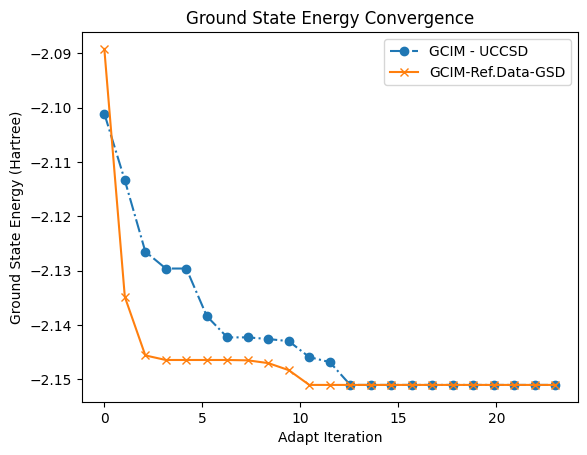

In [7]:
import numpy as np
gs_energy = [-2.101079884775418, -2.1133641432725225, -2.1264814810479424, -2.129593792811551, -2.1295937930064066, -2.138356088241358, -2.1422609652288944, -2.1422609652681004, -2.1425644913736264, -2.1429553155134293, -2.145890119272028, -2.146811950094047, -2.1510071174053937, -2.1510071403453015, -2.151007140345302, -2.1510071403453015, -2.1510071403453033, -2.151007140345302, -2.151007140345302, -2.151007140345301, -2.151007140345303, -2.1510071403453033, -2.1510071403453024]
Bo_data = [ -2.089191838238, -2.134803744923,  -2.145577576449, -2.146419981970,  -2.146419981970,  -2.146419981970, -2.146419981970,-2.146485649327,
            -2.146995533191, -2.148291019032, -2.151007140462, -2.151007140462,  -2.151007140462,-2.151007140462, -2.151007140462,  -2.151007140462, 
             -2.151007140462,-2.151007140462, -2.151007140462, -2.151007140462,-2.151007140462,  -2.151007140462,-2.151007140462      ]
len(gs_energy)
FCI = -2.15100714
it = np.linspace(0, 23, 23)
import matplotlib.pyplot as plt
#plt.figure(figsize=(10, 6))
plt.plot(it, gs_energy, '-.o', label='GCIM - UCCSD')
plt.plot(it, Bo_data, marker='x', label='GCIM-Ref.Data-GSD')
plt.xlabel('Adapt Iteration')
plt.ylabel('Ground State Energy (Hartree)')
plt.legend()
plt.title('Ground State Energy Convergence')
plt.show()


## GSD based ones

In [12]:
#Check the possible excitations
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import itertools
import time
import re
import scipy
from scipy.optimize import minimize
ash_excitation = []
energies = []
excitations= []
old_grad = []
excitationlist = []
generatingfns = []
gs_energy = []
operator_check = []  # To store the highest gradient excitation operators
theta = np.pi/4
print('Theta is', theta)

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity



bond_length = 2.0
symbols = ["H","H","H","H"]
electrons = 4
orbitals = 8
r_bohr = bond_length *1.8897259886 
r_bohr = bond_length * 1.0  # Convert bond length to Bohr radius 
coordinates = np.array([[0.0,0.0, 1*r_bohr], [0.0, 0.0, 2*r_bohr], [0.0,0.0,3*r_bohr],[0.0, 0.0, 4*r_bohr]])
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-3g", method="pyscf")
#hf_state = qchem.hf_state(electrons, qubits)

def adaptvqe(adapt_it = 4, e_th=1e-12):
    ash_excitation = []
    energies = []
    excitations= []
    #Preparation of the Hartree-Fock state in the form of 2^8 states
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def hf_stateprep(wires):
        target_state = np.zeros(2**qubits)
        target_state[240] = 1.0 # Every molecule change, you need to change this index
        qml.StatePrep(target_state, wires=range(qubits))
        return qml.state()

    hf_state = hf_stateprep(wires=qubits)
    #print('HF state is', hf_state)

    #Calculation of HF state
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def circuit(hf_state, electrons, qubits, H):
        #print('Updated hf_state is', hf_state)  
        qml.StatePrep(hf_state, wires=range(qubits))
        return qml.expval(H)  
    
    @qml.qnode(dev)
    def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w)   #Calculating the commutator
        return qml.expval(res)
    
    # Commutator calculation for other states except HF state
    @qml.qnode(dev)
    def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w) #Calculating the commutator
        return qml.expval(res)
    #Applyign the givens rotation to the HF state
    @qml.qnode(dev)
    def new_state(hf_state, ash_excitation, qubits):
        qml.StatePrep(hf_state, wires=range(qubits))
        for i in range(len(ash_excitation)):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=theta, wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=theta, wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.state()
    
    #Measurement of new state
    dev_meas = qml.device("lightning.qubit", wires=qubits, shots=1000)
    @qml.qnode(dev_meas)
    def measure(ostate):
        qml.StatePrep(ostate, wires=range(qubits))
        return qml.counts()
    
    @qml.qnode(dev)
    def ind_state(ash_excitation):
        qml.StatePrep(hf_state, wires=range(qubits))
        print('Individual excitation is', ash_excitation)
        if len(ash_excitation) == 4 :
                qml.FermionicDoubleExcitation(weight=theta, wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
        elif len(ash_excitation) == 2:
                qml.FermionicSingleExcitation(weight=theta, wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.state()


    print('HF state is', circuit(hf_state, electrons, qubits, H))
    singles, doubles = qml.qchem.excitations(electrons, orbitals)

    
    op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in GSD_singles]
    print('op1 is', op1[0])
    op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in GSD_doubles]
    operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
    print('The operator pool length is', len(operator_pool))
    states = [hf_state]
    max_operator = None

    for j in range(1, adapt_it):
        print('The adapt iteration now is', j)  #Adapt iteration
        max_value = float('-inf')
        #max_operator = None
        k = states[-1] if states else hf_state  # if states is empty, fall back to hf_state
        counts1 = measure(k)  #Measure the current state
        print('The measurement of new state is', counts1)
        print(f'The operator check for this iteration {j} is', operator_check)
        for i in operator_pool:
            if i not in operator_check:  # Check if the operator is already used
                #print('The current excitation operator is', i) #Current excitation operator - fermionic one
                #print('The value of  operator check is', operator_check)  #Max excitation operator
                w = qml.fermi.jordan_wigner(i)  #JW transformation
                if np.array_equal(k, hf_state): # If the current state is the HF state
                    current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated  
                else:
                    current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated
                #print(f'The expectation value of {i} is', current_value)

                if current_value > max_value:
                    max_value = current_value
                    max_operator = i

        print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value
        operator_check.append(max_operator)
        # Convert operator to excitations and append to ash_excitation
        indices_str = re.findall(r'\d+', str(max_operator))
        excitations1 = [int(index) for index in indices_str]
        print('Highest gradient excitation is', excitations1)
        ash_excitation.append(excitations1)
        print('ash_excitation is', ash_excitation)
        print('The length of ash_excitation before generating matrix is', len(ash_excitation))

        
        #Now apply the givens rotation for it. 
        ostate = new_state(hf_state, ash_excitation, qubits)
        print(qml.draw(new_state, max_length=100)(hf_state,ash_excitation, qubits))
        #Measuring the state
        counts = measure(ostate)
        print('State count after Generating function is', counts)
        if j >= 2:
            states.append(ind_state(ash_excitation[-1]))  # Append the individual excitation state
            counts_ind = measure(states[-1])
            print('The individula states counts', counts_ind)
        else:
            print('Skipping individual excitation state for j < 2')
        states.append(ostate)
        print(f'After adding the states the adapt iteration is {j} and no of states',len(states))
        M = np.zeros((len(states), len(states)), dtype=complex)  # Initialize H with zeros
        S = np.zeros((len(states), len(states)), dtype=complex)  # Initialize S matrix with zeros
        Ham_matrix = qml.matrix(H, wire_order=range(qubits))  # Get the Hamiltonian matrix
        # Now we need to fill the H and S matrices
        for i in range(len(states)):
            for j in range(len(states)):
                #print('The value of i and j is', i, j)
                left_op = states[i].T.conj()
                right_op = states[j]
                M[i,j] = left_op.dot(Ham_matrix.dot(right_op)).real
                S[i,j] = left_op.dot(right_op).real
     
                
                if i != j:
                    M[j,i] = M[i,j].conj()
                    S[j,i] = S[i,j].conj()
        n = S.shape[0]
        epsilon = 1e-10
        S_reg = S + epsilon * np.eye(n)
        print(f'S matrix with {i} and {j} is', S)
        print('Hamiltonian Matrix with', i, j, 'is', M)
        print('The shape of S matrix is', S.shape)  
        eig,evec=scipy.linalg.eigh(M,S_reg)
        print('Eigenvalues are', eig)
        gs_energy.append(eig[0])
        print('Ground state energy is', gs_energy) 
          
    return ash_excitation, states,eig,gs_energy, Ham_matrix,hf_state


Theta is 0.7853981633974483


In [13]:
ash_excitation, states,eig,gs_energy,Ham_matrix, hf_state = adaptvqe(adapt_it=5, e_th=1e-12)

HF state is -2.075242826741247
op1 is a⁺(0) a(2)
The operator pool length is 36
The adapt iteration now is 1
The measurement of new state is {'11110000': 1000}
The operator check for this iteration 1 is []


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.2747856899916047 for operator a⁺(2) a⁺(3) a(4) a(5)
Highest gradient excitation is [2, 3, 4, 5]
ash_excitation is [[2, 3, 4, 5]]
The length of ash_excitation before generating matrix is 1
0: ─╭|Ψ⟩──────────────────────────────────┤  State
1: ─├|Ψ⟩──────────────────────────────────┤  State
2: ─├|Ψ⟩─╭FermionicDoubleExcitation(0.79)─┤  State
3: ─├|Ψ⟩─├FermionicDoubleExcitation(0.79)─┤  State
4: ─├|Ψ⟩─├FermionicDoubleExcitation(0.79)─┤  State
5: ─├|Ψ⟩─╰FermionicDoubleExcitation(0.79)─┤  State
6: ─├|Ψ⟩──────────────────────────────────┤  State
7: ─╰|Ψ⟩──────────────────────────────────┤  State
State count after Generating function is {'11001100': 149, '11110000': 851}
Skipping individual excitation state for j < 2
After adding the states the adapt iteration is 1 and no of states 2
S matrix with 1 and 1 is [[1.        +0.j 0.92387953-0.j]
 [0.92387953+0.j 1.        +0.j]]
Hamiltonian Matrix with 1 1 is [[-2.07524283+0.j -1.96985234-0.j]
 [-1.96985234+0.j -2.06

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.30404637630887793 for operator a⁺(4) a⁺(5) a(2) a(3)
Highest gradient excitation is [4, 5, 2, 3]
ash_excitation is [[2, 3, 4, 5], [4, 5, 2, 3]]
The length of ash_excitation before generating matrix is 2
0: ─╭|Ψ⟩───────────────────────────────────────────────────────────────────┤  State
1: ─├|Ψ⟩───────────────────────────────────────────────────────────────────┤  State
2: ─├|Ψ⟩─╭FermionicDoubleExcitation(0.79)─╭FermionicDoubleExcitation(0.79)─┤  State
3: ─├|Ψ⟩─├FermionicDoubleExcitation(0.79)─├FermionicDoubleExcitation(0.79)─┤  State
4: ─├|Ψ⟩─├FermionicDoubleExcitation(0.79)─├FermionicDoubleExcitation(0.79)─┤  State
5: ─├|Ψ⟩─╰FermionicDoubleExcitation(0.79)─╰FermionicDoubleExcitation(0.79)─┤  State
6: ─├|Ψ⟩───────────────────────────────────────────────────────────────────┤  State
7: ─╰|Ψ⟩───────────────────────────────────────────────────────────────────┤  State
State count after Generating function is {'11110000': 1000}
Individual excitation is [4, 5, 2

TypeError: list indices must be integers or slices, not FermiWord

In [30]:

dev = qml.device("lightning.qubit", wires=qubits)
@qml.qnode(dev)
def measure(ostate):
    qml.StatePrep(ostate, wires=range(qubits))
    return qml.counts()


In [29]:
hf_state = np.array([1,1,1,1,0,0,0,0])  # Example HF state for testing
qubits = 8
theta = np.pi / 4  # Example angle for excitation
dev = qml.device("lightning.qubit", wires=qubits)
@qml.qnode(dev)
def summa():
    qml.BasisState(hf_state, wires=range(qubits))   
    qml.SingleExcitation(theta, wires=[1, 7])
    return qml.state()


#counts = measure(summa())
print(summa())

[ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.     

In [11]:
HF = 2.0752428267412473
[0,6]@45 = 1.9345721864356995
[6,0]@45 = 1.9345721864356995

[]

In [26]:
UCCSDdata = [-2.101079884775418, -2.1133641432725225, -2.115927569418881, -2.1222191923137013, -2.1272019800287856, -2.138953854229751, -2.1420101776151848, -2.1484533489398685, -2.1507996326556653, -2.1507996326682326, -2.150820572596597, -2.1508377048541076, -2.1508684974595518, -2.151007140193063, -2.151007140193063, -2.1510071401930615, -2.151007140193064, -2.151007140193063, -2.1510071401930646]
len(UCCSDdata)

19